In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Importing data

In [3]:
df = pd.read_csv('data.csv')
df = df.drop('row.names',axis=1)
df['famhist'] = df['famhist'].replace({'Present': 1, 'Absent': 0})
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


# Linear Regression

### 1)
Explain what variable is predicted based on which other variables and what
you hope to accomplish by the regression. Mention your feature transformation
choices such as one-of-K coding. Since we will use regularization momentarily,
apply a feature transformation to your data matrix X such that each column
has mean 0 and standard deviation 1.

In [4]:
target_variable = 'sbp'
features = df.drop(columns=[target_variable]).columns

# Prepare the feature matrix X and the target vector y
X = df[features]
y = df[target_variable]

# We have used one-of-K coding for feature transformation by substituting famhist = present or absent by 1 or 0, respectively

# Feature scaling so that each feature column has mean = 0 and standard deviation = 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df.head()

,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.823073,0.478412,-0.295503,1.185854,-0.418470,-0.176786,3.277738,0.629336,1.373863
1,-0.790237,-0.159680,0.412140,-0.843274,0.193344,0.671373,-0.612745,1.383115,1.373863
2,-0.774980,-0.609245,0.884332,1.185854,-0.112563,0.735519,-0.541183,0.218184,-0.727875
3,0.842264,0.807126,1.624141,1.185854,-0.214532,1.412621,0.295062,1.040488,1.373863
4,2.171805,-0.599577,0.305351,1.185854,0.703189,-0.012856,1.647775,0.423760,1.373863


### 2)

Introduce a regularization parameter λ as discussed in chapter 14 of the lecture
notes, and estimate the generalization error for different values of λ. Specifically, choose a reasonable range of values of λ (ideally one where the generalization error first drop and then increases), and for each value use K = 10 fold
cross-validation (algorithm 5) to estimate the generalization error.
Include a figure of the estimated generalization error as a function of λ in the
report and briefly discuss the result.

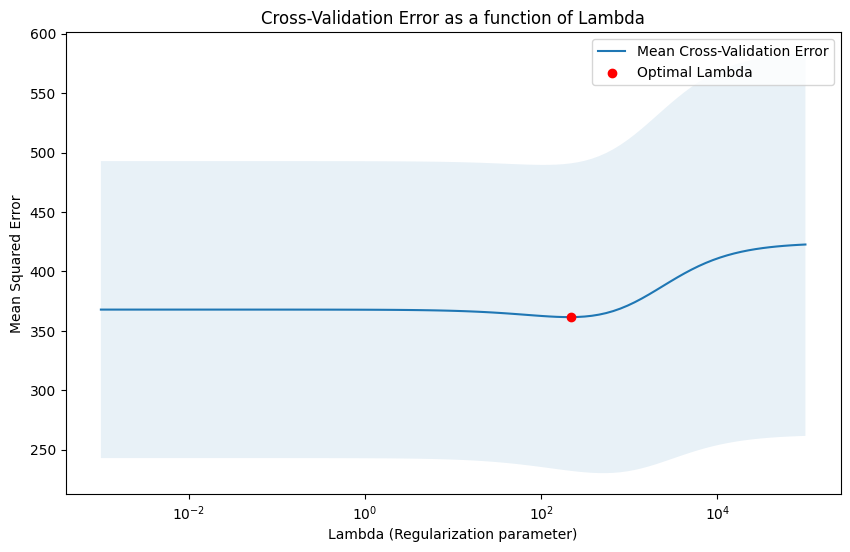

The optimal value of lambda is: 215.44346900318865


In [8]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Set the range of lambda (alpha in scikit-learn) to test
# np.logspace returns numbers spaced evenly on a log scale, starts at 10^-4, ends at 10^4, and generates 100 points
lambda_range = np.logspace(-3, 5, 100)

# Placeholder for cross-validation scores
cross_val_scores_mean = []
cross_val_scores_std = []

# Perform 10-fold cross-validation for each value of lambda (alpha)
for lambda_value in lambda_range:
    ridge_model = Ridge(alpha=lambda_value)
    # Scoring negative mean squared error to use as a loss function where lower values are better
    scores = cross_val_score(ridge_model, X_scaled_df, y, cv=10, scoring='neg_mean_squared_error')
    
    cross_val_scores_mean.append(-np.mean(scores))  # Convert to positive mean squared error
    cross_val_scores_std.append(np.std(scores))

# Convert to numpy arrays for plotting
cross_val_scores_mean = np.array(cross_val_scores_mean)
cross_val_scores_std = np.array(cross_val_scores_std)

optimal_lambda_index = np.argmin(cross_val_scores_mean)
optimal_lambda = lambda_range[optimal_lambda_index]

# Plot the mean cross-validation scores against the lambda values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.semilogx(lambda_range, cross_val_scores_mean, label='Mean Cross-Validation Error')
plt.fill_between(lambda_range, cross_val_scores_mean - cross_val_scores_std, 
                 cross_val_scores_mean + cross_val_scores_std, alpha=0.1)
plt.scatter(optimal_lambda, np.min(cross_val_scores_mean), color='red', zorder=5, label='Optimal Lambda')
plt.xlabel('Lambda (Regularization parameter)')
plt.ylabel('Mean Squared Error')
plt.title('Cross-Validation Error as a function of Lambda')
plt.legend()
plt.show()

print(f"The optimal value of lambda is: {optimal_lambda}")



### 3)

Explain how the output, y, of the linear model with the lowest generalization
error (as determined in the previous question) is computed for a given input
x. What is the effect of an individual attribute in x on the output, y, of the
linear model? Does the effect of individual attributes make sense based on your
understanding of the problem?

In [6]:
# Train Ridge model with the optimal lambda
optimal_ridge_model = Ridge(alpha=optimal_lambda)
optimal_ridge_model.fit(X_scaled_df, y)

# Obtain the coefficients and the intercept
optimal_coefficients = optimal_ridge_model.coef_
optimal_intercept = optimal_ridge_model.intercept_

# Print the intercept
print(f"The optimal intercept is {optimal_intercept:.4f}")

# Print each feature with its corresponding coefficient
for feature, coef in zip(features, optimal_coefficients):
    print(f"The optimal coefficient of {feature} is {coef:.4f}")

The optimal intercept is 138.3268
The optimal coefficient of tobacco is 0.8911
The optimal coefficient of ldl is 0.2397
The optimal coefficient of adiposity is 2.3625
The optimal coefficient of famhist is -0.1158
The optimal coefficient of typea is -0.6769
The optimal coefficient of obesity is 1.2881
The optimal coefficient of alcohol is 1.3981
The optimal coefficient of age is 3.5084
The optimal coefficient of chd is 1.1041


In [7]:
from IPython.display import display, Latex

# Prepare the LaTeX string for the model equation, replacing 'y' with the target variable name
model_equation = '{} = {:.4f}'.format(target_variable, optimal_intercept)
for feature, coef in zip(features, optimal_coefficients):
    if coef >= 0:  # for positive coefficients, add a plus sign
        model_equation += '\\newline + {:.4f} \\cdot \\text{{{}}}'.format(coef, feature)
    else:  # for negative coefficients, the minus sign is already included
        model_equation += '\\newline {:.4f} \\cdot \\text{{{}}}'.format(coef, feature)

# LaTeX for newline is '\\', but we don't typically put newlines in equations
# If you want to break the line after a certain number of features, you can use '\\\\' in LaTeX

# Convert the string to a Latex object for pretty printing
model_equation_latex = f"$$ {model_equation} $$"

# Display the equation using LaTeX
display(Latex(model_equation_latex))


<IPython.core.display.Latex object>